In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from collections import defaultdict
import random
from tqdm import tqdm

In [2]:
DATA_DIR = "Data" # path to directory containing u.data, u.item, u.user
RATING_FILE = os.path.join(DATA_DIR, "u.data")
ITEM_FILE = os.path.join(DATA_DIR, "u.item")
USER_FILE = os.path.join(DATA_DIR, "u.user")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---------------------- Load Data ---------------------- #

In [3]:
def load_movielens_100k(rating_file=RATING_FILE, item_file=ITEM_FILE):
    # u.data: user id | item id | rating | timestamp
    names = ["user_id", "item_id", "rating", "timestamp"]
    ratings = pd.read_csv(rating_file, sep="\t", names=names, engine='python')


    # u.item: movie id | movie title | release date | ... (pipe-separated)
    items = pd.read_csv(item_file, sep="|", header=None, encoding='latin-1', engine='python')
    items = items[[0, 1]]
    items.columns = ["item_id", "title"]


    return ratings, items

# ----------------- Build user-item matrix ----------------- #


In [4]:


def build_user_item_matrix(ratings):
    users = ratings['user_id'].unique()
    items = ratings['item_id'].unique()
    users_sorted = np.sort(users)
    items_sorted = np.sort(items)


    user_to_idx = {u: i for i, u in enumerate(users_sorted)}
    item_to_idx = {m: j for j, m in enumerate(items_sorted)}


    R = np.zeros((len(users_sorted), len(items_sorted)), dtype=np.float32)
    for _, row in ratings.iterrows():
        R[user_to_idx[row['user_id']], item_to_idx[row['item_id']]] = row['rating']


    return R, user_to_idx, item_to_idx, users_sorted, items_sorted

# ------------ Train/Test split (leave-one-out) ------------- #

In [5]:
def leave_one_out_split(ratings, seed=SEED):
# For each user select one random rating as test; rest are train
    train_rows = []
    test_rows = []


    grouped = ratings.groupby('user_id')
    for user, group in grouped:
        if len(group) == 0:
            continue
        if len(group) == 1:
            # If only one rating, keep it in train to avoid empty train; put none in test
            train_rows.append(group.index[0])
            continue
        test_idx = group.sample(n=1, random_state=seed).index[0]
        for idx in group.index:
            if idx == test_idx:
                test_rows.append(idx)
            else:
                train_rows.append(idx)


    train = ratings.loc[train_rows].reset_index(drop=True)
    test = ratings.loc[test_rows].reset_index(drop=True)
    return train, test





# ------------- Compute user similarity matrix -------------


In [6]:
def compute_user_similarity(R_train, kind='cosine'):
    sim = cosine_similarity(R_train)
# zero diagonal (optional, keep if you don't want self-similarity)
    np.fill_diagonal(sim, 0.0)
    return sim




# --------------Prediction--------------

In [7]:
def predict_ratings_user_based(R_train, user_sim, k=None):
    U, I = R_train.shape
    preds = np.zeros((U, I), dtype=np.float32)


    if k is None:
        sim_sums = np.sum(np.abs(user_sim), axis=1)
        sim_sums[sim_sums == 0] = 1e-8
        preds = user_sim.dot(R_train) / sim_sums[:, None]
    else:
# use top-k neighbors for each user
        for u in range(U):
# get top k neighbors indices (largest similarity)
            neigh_idx = np.argsort(-user_sim[u])[:k]
            sims = user_sim[u, neigh_idx]
            ratings = R_train[neigh_idx]
            denom = np.sum(np.abs(sims))
            if denom == 0:
                preds[u] = 0
            else:
                preds[u] = np.dot(sims, ratings) / denom
    return preds

# ------------------ Recommend top-N unseen ------------------

In [8]:
def recommend_top_n(preds, R_train, user_idx, item_idx_to_id, N=10):
    user_pred = preds[user_idx]
    seen_mask = R_train[user_idx] > 0
    unseen_indices = np.where(~seen_mask)[0]
    # sort unseen by predicted rating descending
    top_unseen_sorted = unseen_indices[np.argsort(-user_pred[unseen_indices])]
    top_n = top_unseen_sorted[:N]
    return [item_idx_to_id[i] for i in top_n], user_pred[top_n]

# ------------------ Evaluation ------------------

In [9]:
def precision_at_k_for_user(test_items, recommended_items, k):
# test_items: set of item ids that are in test for this user
# recommended_items: list (ordered) of recommended item ids
    recommended_k = recommended_items[:k]
    hits = sum([1 for r in recommended_k if r in test_items])
    return hits / k

In [10]:
def evaluate_precision_at_k(preds, R_train, test_ratings, users_sorted, items_sorted, user_to_idx, item_to_idx, k=10, N=10):
# test_ratings: dataframe with columns user_id, item_id, rating
# We'll compute precision@k averaged over users who have at least one test item
    user_tests = test_ratings.groupby('user_id')['item_id'].apply(set).to_dict()


    item_idx_to_id = {idx: item_id for item_id, idx in item_to_idx.items()}


    precisions = []
    for user_id, test_items in user_tests.items():
        uidx = user_to_idx.get(user_id)
        if uidx is None:
            continue
        rec_items, _ = recommend_top_n(preds, R_train, uidx, item_idx_to_id, N=N)
        p = precision_at_k_for_user(test_items, rec_items, k)
        precisions.append(p)


    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

In [11]:
def run_all(data_dir=DATA_DIR, k_neighbors=None, K_eval=10, N_rec=10):
    ratings, items = load_movielens_100k(os.path.join(data_dir, 'u.data'), os.path.join(data_dir, 'u.item'))
    train_df, test_df = leave_one_out_split(ratings)


    # Build matrices (use IDs present in train+test combined to be safe)
    all_ratings = pd.concat([train_df, test_df], ignore_index=True)
    R_train, user_to_idx, item_to_idx, users_sorted, items_sorted = build_user_item_matrix(train_df)
    item_idx_to_id = {v: k for k, v in item_to_idx.items()}

    user_sim = compute_user_similarity(R_train)

    preds = predict_ratings_user_based(R_train, user_sim, k=k_neighbors)
    prec = evaluate_precision_at_k(preds, R_train, test_df, users_sorted, items_sorted, user_to_idx, item_to_idx, k=K_eval, N=N_rec)
    print(f"Precision@{K_eval} (averaged over users): {prec:.4f}")


    return {
    'R_train': R_train,
    'user_sim': user_sim,
    'preds': preds,
    'train_df': train_df,
    'test_df': test_df,
    'user_to_idx': user_to_idx,
    'item_to_idx': item_to_idx,
    'items': items
    }

In [12]:
def recommend_for_user(model_data, user_id, N=10):
    R_train = model_data['R_train']
    preds = model_data['preds']
    user_to_idx = model_data['user_to_idx']
    item_to_idx = model_data['item_to_idx']
    items = model_data['items']


    if user_id not in user_to_idx:
        raise ValueError("User id not found in training users")
    uidx = user_to_idx[user_id]


    item_idx_to_id = {v: k for k, v in item_to_idx.items()}
    rec_item_ids, scores = recommend_top_n(preds, R_train, uidx, item_idx_to_id, N=N)


# get titles
    title_map = items.set_index('item_id')['title'].to_dict()
    rec_titles = [(iid, title_map.get(iid, "<unknown>"), float(score)) for iid, score in zip(rec_item_ids, scores)]
    return rec_titles

In [13]:
if __name__ == '__main__':
# Update DATA_DIR above if necessary
    print("Running user-based recommender (Movielens 100k)")
    model = run_all(DATA_DIR, k_neighbors=30, K_eval=10, N_rec=10)


    # Example recommendations for user id 50
    uid = 50
    try:
        recs = recommend_for_user(model, uid, N=10)
        print(f"Top recommendations for user {uid}:")
        for iid, title, score in recs:
            print(f" - {title} (item {iid}) — predicted score {score:.3f}")
    except Exception as e:
        print(str(e))

Running user-based recommender (Movielens 100k)
Precision@10 (averaged over users): 0.0281
Top recommendations for user 50:
 - Twelve Monkeys (1995) (item 7) — predicted score 2.283
 - Star Wars (1977) (item 50) — predicted score 2.198
 - Godfather, The (1972) (item 127) — predicted score 2.002
 - Contact (1997) (item 258) — predicted score 1.946
 - Secrets & Lies (1996) (item 285) — predicted score 1.892
 - Welcome to the Dollhouse (1995) (item 93) — predicted score 1.888
 - Titanic (1997) (item 313) — predicted score 1.881
 - Liar Liar (1997) (item 294) — predicted score 1.820
 - Donnie Brasco (1997) (item 293) — predicted score 1.804
 - Bound (1996) (item 129) — predicted score 1.760


# Data exploration, modeling, plots, and merged data saving

In [14]:

# Flexible data-loading for Movielens 100k / Kaggle variants.
# This cell tries several common filenames and locations. Run this cell first.
import os, pandas as pd, numpy as np
from pathlib import Path

SEARCH_PATHS = [
    Path('.'),
    Path('./data'),
    Path('/mnt/data'),
    Path('ml-100k'),
    Path('./ml-100k')
]

found = {}

# candidate files and readers
candidates = {
    'u.data': lambda p: pd.read_csv(p, sep='\t', names=['user_id','item_id','rating','timestamp'], engine='python'),
    'u.item': lambda p: pd.read_csv(p, sep='|', header=None, encoding='latin-1', engine='python'),
    'u.user': lambda p: pd.read_csv(p, sep='|', header=None, engine='python'),
    'ratings.csv': lambda p: pd.read_csv(p),
    'movies.csv': lambda p: pd.read_csv(p),
    'users.csv': lambda p: pd.read_csv(p)
}

# search
for base in SEARCH_PATHS:
    for fname in candidates.keys():
        p = base / fname
        if p.exists():
            try:
                df = candidates[fname](p)
                found[fname] = {'path': str(p), 'df': df}
                print(f'Found {fname} at {p} (shape={df.shape})')
            except Exception as e:
                print(f'Found {fname} at {p} but failed to read: {e}')

# Basic normalization to Ratings, Movies, Users dataframes
ratings_df = None
movies_df = None
users_df = None

# prioritize classic files
if 'u.data' in found:
    ratings_df = found['u.data']['df'].copy()
    ratings_df.columns = ['user_id','item_id','rating','timestamp']
if 'ratings.csv' in found and ratings_df is None:
    # try common columns
    r = found['ratings.csv']['df']
    if {'userId','movieId','rating'}.issubset(r.columns):
        r = r.rename(columns={'userId':'user_id','movieId':'item_id'})
    ratings_df = r.copy()

if 'u.item' in found:
    # u.item: first two columns are id and title
    ui = found['u.item']['df'].copy()
    ui = ui.iloc[:, :2]
    ui.columns = ['item_id','title']
    movies_df = ui
elif 'movies.csv' in found and movies_df is None:
    m = found['movies.csv']['df']
    if {'movieId','title'}.issubset(m.columns):
        m = m.rename(columns={'movieId':'item_id'})
    movies_df = m.copy()

if 'u.user' in found:
    uu = found['u.user']['df'].copy()
    # u.user columns: id | age | gender | occupation | zip
    if uu.shape[1] >= 5:
        uu = uu.iloc[:, :5]
        uu.columns = ['user_id','age','gender','occupation','zip_code']
    users_df = uu
elif 'users.csv' in found and users_df is None:
    users_df = found['users.csv']['df'].copy()
    if 'userId' in users_df.columns:
        users_df = users_df.rename(columns={'userId':'user_id'})

print('\nSummary of loaded objects:')
print('ratings_df:', getattr(ratings_df,'shape',None))
print('movies_df:', getattr(movies_df,'shape',None))
print('users_df:', getattr(users_df,'shape',None))

if ratings_df is None:
    raise FileNotFoundError('No ratings file found. Place u.data or ratings.csv in the notebook folder or ./data and re-run.')


Found u.data at data\u.data (shape=(100000, 4))
Found u.item at data\u.item (shape=(1682, 24))
Found u.user at data\u.user (shape=(943, 5))

Summary of loaded objects:
ratings_df: (100000, 4)
movies_df: (1682, 2)
users_df: (943, 5)


In [15]:

# Merge ratings, movies, and users into a single tidy dataframe and save as merged_data.csv
import os
from pathlib import Path

# ratings_df, movies_df, users_df assumed to exist after running the loading cell
merged = ratings_df.copy()

if 'title' in merged.columns:
    # already merged?
    pass
else:
    if movies_df is not None:
        # ensure item_id types align
        merged = merged.merge(movies_df[['item_id','title']].drop_duplicates(), on='item_id', how='left')
    if users_df is not None:
        merged = merged.merge(users_df, on='user_id', how='left')

# basic cleanup
merged['rating'] = pd.to_numeric(merged['rating'], errors='coerce')
merged = merged.dropna(subset=['user_id','item_id','rating'])

out_path = Path('.') / 'merged_data.csv'
merged.to_csv(out_path, index=False)
print(f'Saved merged data to: {out_path} (shape={merged.shape})')

# expose merged as a variable
merged_df = merged
merged_df.head(3)


Saved merged data to: merged_data.csv (shape=(100000, 9))


,user_id,item_id,rating,timestamp,title,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),49,M,writer,55105
1,186,302,3,891717742,L.A. Confidential (1997),39,F,executive,00000
2,22,377,1,878887116,Heavyweights (1994),25,M,writer,40206


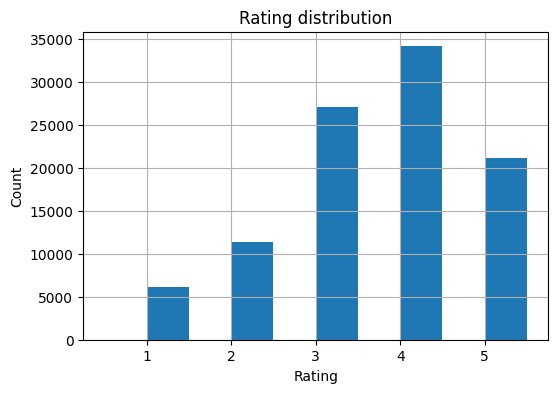

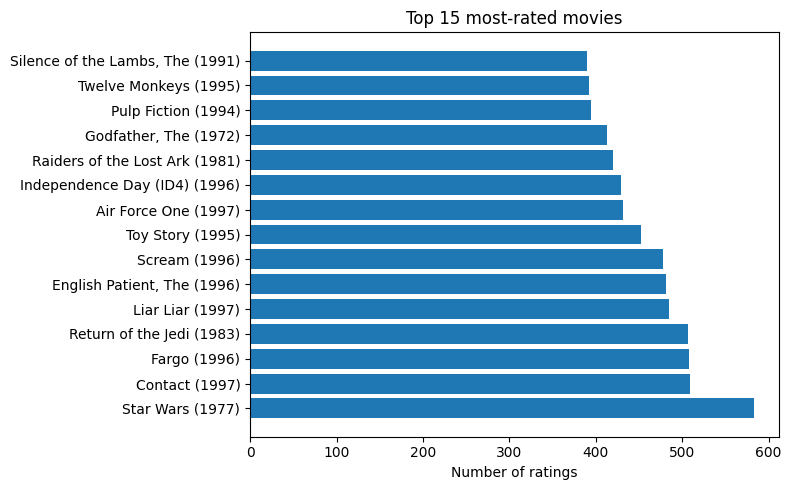

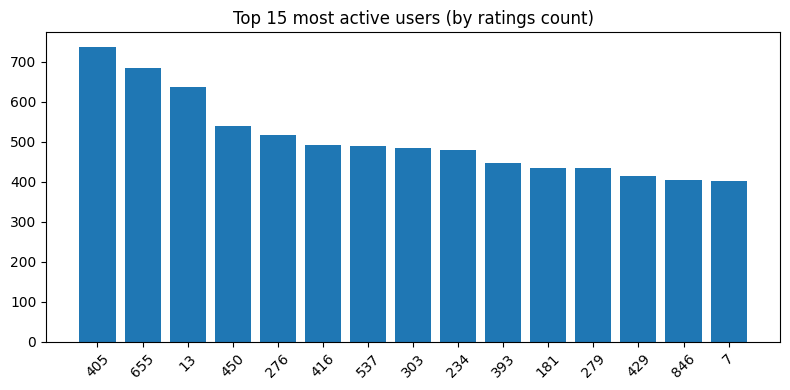

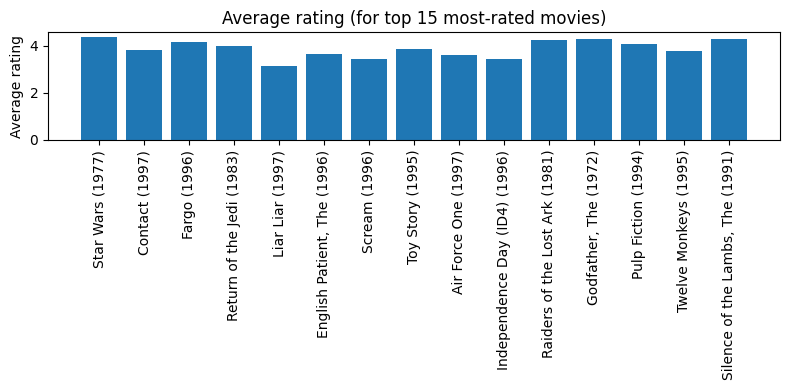

In [16]:

# Exploratory plots: rating distribution, top movies by count, top users by count, avg rating per movie.
import matplotlib.pyplot as plt
import numpy as np

# Rating distribution
plt.figure(figsize=(6,4))
plt.hist(merged_df['rating'].astype(float).values, bins=np.arange(0.5, 5.5+1e-9, 0.5))
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Top 15 movies by number of ratings
top_movies = merged_df.groupby(['item_id','title']).size().reset_index(name='count').sort_values('count', ascending=False).head(15)
plt.figure(figsize=(8,5))
plt.barh(range(len(top_movies)), top_movies['count'][::-1])
plt.yticks(range(len(top_movies)), top_movies['title'][::-1])
plt.xlabel('Number of ratings')
plt.title('Top 15 most-rated movies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top 15 active users
top_users = merged_df.groupby('user_id').size().reset_index(name='count').sort_values('count', ascending=False).head(15)
plt.figure(figsize=(8,4))
plt.bar(range(len(top_users)), top_users['count'])
plt.xticks(range(len(top_users)), top_users['user_id'], rotation=45)
plt.title('Top 15 most active users (by ratings count)')
plt.tight_layout()
plt.show()

# Average rating per movie (top 15 by count)
avg_rating = merged_df.groupby(['item_id','title'])['rating'].mean().reset_index().set_index(['item_id','title']).loc[top_movies.set_index(['item_id','title']).index].reset_index()
plt.figure(figsize=(8,4))
plt.bar(range(len(avg_rating)), avg_rating['rating'])
plt.xticks(range(len(avg_rating)), avg_rating['title'], rotation=90)
plt.title('Average rating (for top 15 most-rated movies)')
plt.ylabel('Average rating')
plt.tight_layout()
plt.show()


Precision@1: 0.0626
Precision@2: 0.0514
Precision@3: 0.0463
Precision@4: 0.0411
Precision@5: 0.0382
Precision@6: 0.0361
Precision@7: 0.0341
Precision@8: 0.0322
Precision@9: 0.0299
Precision@10: 0.0281
Precision@11: 0.0255
Precision@12: 0.0234
Precision@13: 0.0216
Precision@14: 0.0201
Precision@15: 0.0187
Precision@16: 0.0176
Precision@17: 0.0165
Precision@18: 0.0156
Precision@19: 0.0148
Precision@20: 0.0141


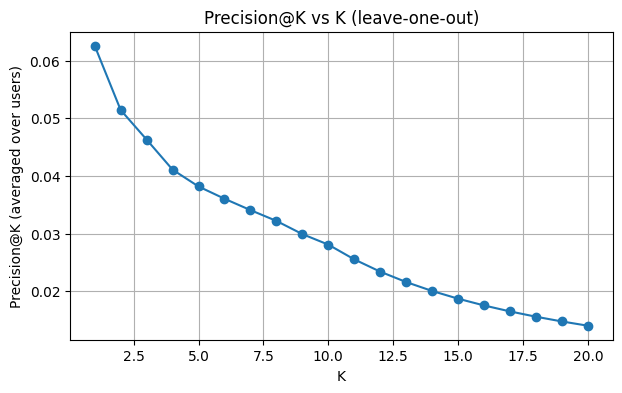

Sample user id: 196
Top-10 recommended (item_id, title):
- 100 Fargo (1996)
- 50 Star Wars (1977)
- 204 Back to the Future (1985)
- 216 When Harry Met Sally... (1989)
- 191 Amadeus (1984)
- 275 Sense and Sensibility (1995)
- 1 Toy Story (1995)
- 435 Butch Cassidy and the Sundance Kid (1969)
- 98 Silence of the Lambs, The (1991)
- 56 Pulp Fiction (1994)


In [17]:

# User-based collaborative filtering recommender and evaluation (Precision@K).
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Build user-item matrix from merged_df (train on all data for the demo; for evaluation use leave-one-out)
users = np.sort(merged_df['user_id'].unique())
items = np.sort(merged_df['item_id'].unique())
user_to_idx = {u:i for i,u in enumerate(users)}
item_to_idx = {m:j for j,m in enumerate(items)}

R = np.zeros((len(users), len(items)), dtype=np.float32)
for _, row in merged_df.iterrows():
    try:
        R[user_to_idx[row['user_id']], item_to_idx[row['item_id']]] = float(row['rating'])
    except Exception:
        pass

# compute user similarity (cosine)
user_sim = cosine_similarity(R)
np.fill_diagonal(user_sim, 0.0)

def predict_ratings(R_train, user_sim, k=None):
    U, I = R_train.shape
    preds = np.zeros((U, I), dtype=np.float32)
    if k is None:
        sim_sums = np.sum(np.abs(user_sim), axis=1)
        sim_sums[sim_sums == 0] = 1e-8
        preds = user_sim.dot(R_train) / sim_sums[:, None]
    else:
        for u in range(U):
            neigh_idx = np.argsort(-user_sim[u])[:k]
            sims = user_sim[u, neigh_idx]
            ratings = R_train[neigh_idx]
            denom = np.sum(np.abs(sims))
            if denom == 0:
                preds[u] = 0
            else:
                preds[u] = np.dot(sims, ratings) / denom
    return preds

# Quick leave-one-out evaluation for Precision@K
from collections import defaultdict
def leave_one_out_precision_at_k(df, K=10, k_neighbors=30, N_rec=10):
    # For each user, hold out one rating as test (if user has >1 ratings)
    grouped = df.groupby('user_id')
    test = []
    train_rows = []
    for user, group in grouped:
        if len(group) == 1:
            train_rows.extend(group.index.tolist())
            continue
        test_idx = group.sample(n=1, random_state=42).index[0]
        test.append(df.loc[test_idx])
        train_rows.extend([i for i in group.index if i != test_idx])
    train_df = df.loc[train_rows].reset_index(drop=True)
    test_df = pd.DataFrame(test).reset_index(drop=True)
    # build R_train
    users_train = np.sort(train_df['user_id'].unique())
    items_train = np.sort(train_df['item_id'].unique())
    u2i = {u:i for i,u in enumerate(users_train)}
    it2i = {m:j for j,m in enumerate(items_train)}
    R_train = np.zeros((len(users_train), len(items_train)), dtype=np.float32)
    for _, row in train_df.iterrows():
        R_train[u2i[row['user_id']], it2i[row['item_id']]] = float(row['rating'])
    # similarity on train users x train users
    sim = cosine_similarity(R_train)
    np.fill_diagonal(sim, 0.0)
    preds = predict_ratings(R_train, sim, k=k_neighbors)
    # evaluate precision@K
    precisions = []
    item_idx_to_id = {v:k for k,v in it2i.items()}
    for _, row in test_df.iterrows():
        uid = row['user_id']
        iid = row['item_id']
        if uid not in u2i or iid not in it2i:
            continue
        uidx = u2i[uid]
        # recommend top N unseen
        seen = R_train[uidx] > 0
        user_pred = preds[uidx]
        unseen_idx = np.where(~seen)[0]
        recs = unseen_idx[np.argsort(-user_pred[unseen_idx])][:N_rec]
        rec_item_ids = [item_idx_to_id[r] for r in recs]
        hit = 1 if iid in rec_item_ids[:K] else 0
        precisions.append(hit / K)
    return float(np.mean(precisions)) if len(precisions)>0 else 0.0

# Compute Precision@K for a range of K values (e.g., 1..20)
Ks = list(range(1, 21))
precisions_vs_k = []
for K in Ks:
    p = leave_one_out_precision_at_k(merged_df, K=K, k_neighbors=30, N_rec=10)
    precisions_vs_k.append(p)
    print(f'Precision@{K}: {p:.4f}')

# Plot Precision@K vs K
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(Ks, precisions_vs_k, marker='o')
plt.xlabel('K')
plt.ylabel('Precision@K (averaged over users)')
plt.title('Precision@K vs K (leave-one-out)')
plt.grid(True)
plt.show()

# Example: recommend top 10 for a sample user (first user in dataset)
sample_user = merged_df['user_id'].iloc[0]
print('Sample user id:', sample_user)
# Build preds on full R (for demo)
preds_full = predict_ratings(R, user_sim, k=30)
uid_global = user_to_idx[sample_user]
seen_mask = R[uid_global] > 0
unseen_idx = np.where(~seen_mask)[0]
top10 = unseen_idx[np.argsort(-preds_full[uid_global, unseen_idx])][:10]
item_idx_to_id_global = {v:k for k,v in item_to_idx.items()}
rec_item_ids = [item_idx_to_id_global[i] for i in top10]
title_map = merged_df.set_index('item_id')['title'].to_dict()
print('Top-10 recommended (item_id, title):')
for iid in rec_item_ids:
    print('-', iid, title_map.get(iid, '<unknown>'))
